# Stateful LSTM using PyTorch

[References]
- [PyTorch Discussion](https://discuss.pytorch.org/t/confusion-regarding-pytorch-lstms-compared-to-keras-stateful-lstm/44502)
- [PyTorch LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

## What is stateful LSTM?

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary

from data_preprocess import X, y, num_train_samples, num_val_samples, num_test_samples

import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

num_train_samples: 252270
num_val_samples: 84090
num_test_samples: 84091


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

num_features = X.shape[1]
print('Number of features:', num_features)

cpu
Number of features: 14


## Data Loader for Stateful-LSTM

In [3]:
class SequenceDataset(Dataset):
    def __init__(self, X_array, y_array, sampling_rate, sequence_length, delay):
        super(Dataset, self).__init__()

        self.sr = sampling_rate
        self.seq_len = sequence_length
        self.delay = delay
        self.X = torch.tensor(X_array).float()
        self.y = torch.tensor(y_array).float()

    def __len__(self):
        return (self.X.size(0) - self.delay)//self.seq_len

    def __getitem__(self, i): 
        idx = np.arange(i*self.seq_len, i*self.seq_len + self.sr*self.seq_len, self.sr)
        return self.X[idx], self.y[i*self.seq_len+self.delay]

In [4]:
int_sequence = np.arange(130)
dummy_dataset = SequenceDataset(int_sequence, int_sequence,
                                sampling_rate=3, sequence_length=7, 
                                delay=20)
dummy_loader = DataLoader(dummy_dataset, batch_size=3, shuffle=False)

In [5]:
for inputs, targets in dummy_loader:
    # inputs shape : (batch_size, sequence_length)
    # targets shape : (batch_size, )
    print("====================")
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 3, 6, 9, 12, 15, 18] 20
[7, 10, 13, 16, 19, 22, 25] 27
[14, 17, 20, 23, 26, 29, 32] 34
[21, 24, 27, 30, 33, 36, 39] 41
[28, 31, 34, 37, 40, 43, 46] 48
[35, 38, 41, 44, 47, 50, 53] 55
[42, 45, 48, 51, 54, 57, 60] 62
[49, 52, 55, 58, 61, 64, 67] 69
[56, 59, 62, 65, 68, 71, 74] 76
[63, 66, 69, 72, 75, 78, 81] 83
[70, 73, 76, 79, 82, 85, 88] 90
[77, 80, 83, 86, 89, 92, 95] 97
[84, 87, 90, 93, 96, 99, 102] 104
[91, 94, 97, 100, 103, 106, 109] 111
[98, 101, 104, 107, 110, 113, 116] 118


**To use `stateful=True` mode in LSTM (RNN), you should follow the rules below:**

- Do **NOT** shuffle the dataset
- `sequence_stride` = `sequence_length`
- `batch_size` = `sampling_rate`
- Each batch need to have the same number of samples, i.e., the number of samples needs to divisible by `batch_size`.

In [6]:
# Observations will be sampled at one data point per hour
sampling_rate=6

# Observations will go back 5 days (120 hours)
sequence_length = 120

# The target for a sequence will be the temperature 24 hours after the end of the sequence.
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = sampling_rate

train_dataset = SequenceDataset(X[:num_train_samples-sequence_length], 
                                y[:num_train_samples-sequence_length], 
                                sampling_rate=sampling_rate, sequence_length=sequence_length,
                                delay = delay)

valid_dataset = SequenceDataset(X[num_train_samples:num_train_samples+num_val_samples-sequence_length*3], 
                                y[num_train_samples:num_train_samples+num_val_samples-sequence_length*3], 
                                sampling_rate=sampling_rate, sequence_length=sequence_length,
                                delay = delay)

test_dataset = SequenceDataset(X[num_train_samples + num_val_samples-delay*2:-sequence_length*5],
                               y[num_train_samples + num_val_samples-delay*2:-sequence_length*5], 
                               sampling_rate=sampling_rate, sequence_length=sequence_length,
                               delay = delay)


In [7]:
train_loader = DataLoader(train_dataset, batch_size=sampling_rate, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=sampling_rate, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=sampling_rate, shuffle=False)

In [8]:
for samples, targets in test_loader:
    print('samples shape:', samples.shape)
    print('targets shape:', targets.shape)
    break

samples shape: torch.Size([6, 120, 14])
targets shape: torch.Size([6])


## Stateful LSTM model

- Using PyTorch, we store the hidden/cell state vectors from the previous batch. Then we use the vectors as the initial hidden/cell state vectors in the next batch.
- `train` and `test` functions should be changed from those for the original LSTM models.

In [9]:
class stateful_LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(stateful_LSTM_model, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size  = input_size,
                            hidden_size = hidden_size,
                            num_layers  = 1,     # The number of stacked RNN layers
                            batch_first = True            # Default: False
                            )
        self.linear = nn.Linear(in_features = hidden_size, 
                                out_features=1, 
                                bias=True
                                )

    def forward(self, x, h_n, c_n):
        output, (h_n, c_n) = self.lstm(x, (h_n.detach(), c_n.detach()))
        '''
        output size : (batch_size, sequence_length, num_layers * hidden_size)
        -> hidden state vectors (NOT CELL STATE VECTORS) for each time step, for each layer.
        h_n : (num_layers, batch_size, hidden_size) 
        c_n : (num_layers, batch_size, hidden_size)
        '''
        x = h_n.view(-1, self.hidden_size)
        '''
        Reshape to (batch_size, hidden_size) : appropriate shape as linear layer input
        '''
        x = self.linear(x)
        return x, h_n, c_n

In [10]:
hidden_size=16
model = stateful_LSTM_model(input_size=num_features, hidden_size=hidden_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 30

In [11]:
batch_size=sampling_rate

def train(model, trainloader, validloader, criterion, optimizer, epoch, device):
    
    losses = []
    val_losses = []
    model.to(device)
    model.train()

    for i in range(1, epoch+1):
        count = 0
        train_loss = 0
        h_n = torch.zeros(1, batch_size, hidden_size).to(device)
        c_n = torch.zeros(1, batch_size, hidden_size).to(device)
        for X, y in tqdm(trainloader):
            X = X.to(device)
            y = y.to(device)

            output, h_n, c_n = model(X, h_n, c_n)
            loss = criterion(output.view(-1), y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            count += 1

        train_loss /= count
        losses.append(train_loss)

        count = 0
        valid_loss = 0
        h_n = torch.zeros(1, batch_size, hidden_size).to(device)
        c_n = torch.zeros(1, batch_size, hidden_size).to(device)
        with torch.no_grad():
            for X, y in validloader:
                X = X.to(device)
                y = y.to(device)

                output, h_n, c_n = model(X, h_n, c_n)
                loss = criterion(output.view(-1), y)
                valid_loss += loss.item()
                count += 1
            
        valid_loss /= count
        val_losses.append(valid_loss)

        print('EPOCH %d Completed. \n Training Loss: %.3f, Validation Loss: %.3f \n' 
              %(i, train_loss, valid_loss))

    return losses, val_losses

In [12]:
def test(model, evalloader, criterion, device):
    eval_loss = 0
    count = 0
    model.eval()
    predictions = np.empty([0])

    h_n = torch.zeros(1, batch_size, hidden_size).to(device)
    c_n = torch.zeros(1, batch_size, hidden_size).to(device)
    with torch.no_grad():
        for X, y in evalloader:
            X = X.to(device)
            y = y.to(device)

            output, h_n, c_n = model(X, h_n, c_n)
            predictions = np.append(predictions, output.view(-1).numpy())

            loss = criterion(output.view(-1), y)
            eval_loss += loss.item()
            count += 1
        
    eval_loss /= count
    
    return predictions, eval_loss

In [13]:
train_loss, val_loss = train(model, train_loader, valid_loader, criterion, optimizer, EPOCHS, device)

100%|██████████| 349/349 [00:08<00:00, 41.75it/s]


EPOCH 1 Completed. 
 Training Loss: 108.287, Validation Loss: 49.367 



100%|██████████| 349/349 [00:08<00:00, 42.71it/s]


EPOCH 2 Completed. 
 Training Loss: 49.837, Validation Loss: 29.091 



100%|██████████| 349/349 [00:08<00:00, 38.79it/s]


EPOCH 3 Completed. 
 Training Loss: 32.235, Validation Loss: 20.605 



100%|██████████| 349/349 [00:11<00:00, 29.81it/s]


EPOCH 4 Completed. 
 Training Loss: 23.256, Validation Loss: 16.501 



100%|██████████| 349/349 [00:10<00:00, 32.48it/s]


EPOCH 5 Completed. 
 Training Loss: 18.392, Validation Loss: 13.818 



100%|██████████| 349/349 [00:09<00:00, 38.32it/s]


EPOCH 6 Completed. 
 Training Loss: 15.651, Validation Loss: 12.614 



100%|██████████| 349/349 [00:08<00:00, 39.53it/s]


EPOCH 7 Completed. 
 Training Loss: 14.011, Validation Loss: 11.773 



100%|██████████| 349/349 [00:08<00:00, 39.06it/s]


EPOCH 8 Completed. 
 Training Loss: 13.072, Validation Loss: 11.261 



100%|██████████| 349/349 [00:09<00:00, 37.78it/s]


EPOCH 9 Completed. 
 Training Loss: 12.367, Validation Loss: 10.901 



100%|██████████| 349/349 [00:09<00:00, 38.23it/s]


EPOCH 10 Completed. 
 Training Loss: 11.819, Validation Loss: 10.672 



100%|██████████| 349/349 [00:08<00:00, 42.40it/s]


EPOCH 11 Completed. 
 Training Loss: 11.470, Validation Loss: 10.597 



100%|██████████| 349/349 [00:08<00:00, 39.82it/s]


EPOCH 12 Completed. 
 Training Loss: 11.106, Validation Loss: 10.462 



100%|██████████| 349/349 [00:08<00:00, 39.20it/s]


EPOCH 13 Completed. 
 Training Loss: 10.876, Validation Loss: 10.355 



100%|██████████| 349/349 [00:08<00:00, 41.08it/s]


EPOCH 14 Completed. 
 Training Loss: 10.683, Validation Loss: 10.344 



100%|██████████| 349/349 [00:08<00:00, 41.27it/s]


EPOCH 15 Completed. 
 Training Loss: 10.532, Validation Loss: 10.338 



100%|██████████| 349/349 [00:08<00:00, 42.34it/s]


EPOCH 16 Completed. 
 Training Loss: 10.398, Validation Loss: 10.340 



100%|██████████| 349/349 [00:08<00:00, 43.23it/s]


EPOCH 17 Completed. 
 Training Loss: 10.286, Validation Loss: 10.419 



100%|██████████| 349/349 [00:08<00:00, 41.79it/s]


EPOCH 18 Completed. 
 Training Loss: 10.180, Validation Loss: 10.429 



100%|██████████| 349/349 [00:08<00:00, 43.07it/s]


EPOCH 19 Completed. 
 Training Loss: 10.082, Validation Loss: 10.440 



100%|██████████| 349/349 [00:08<00:00, 41.78it/s]


EPOCH 20 Completed. 
 Training Loss: 9.984, Validation Loss: 10.401 



100%|██████████| 349/349 [00:08<00:00, 42.76it/s]


EPOCH 21 Completed. 
 Training Loss: 9.881, Validation Loss: 10.377 



100%|██████████| 349/349 [00:08<00:00, 42.37it/s]


EPOCH 22 Completed. 
 Training Loss: 9.791, Validation Loss: 10.377 



100%|██████████| 349/349 [00:08<00:00, 41.85it/s]


EPOCH 23 Completed. 
 Training Loss: 9.684, Validation Loss: 10.431 



100%|██████████| 349/349 [00:08<00:00, 40.65it/s]


EPOCH 24 Completed. 
 Training Loss: 9.631, Validation Loss: 10.622 



100%|██████████| 349/349 [00:08<00:00, 42.36it/s]


EPOCH 25 Completed. 
 Training Loss: 9.543, Validation Loss: 10.457 



100%|██████████| 349/349 [00:08<00:00, 41.71it/s]


EPOCH 26 Completed. 
 Training Loss: 9.431, Validation Loss: 10.465 



100%|██████████| 349/349 [00:08<00:00, 41.27it/s]


EPOCH 27 Completed. 
 Training Loss: 9.417, Validation Loss: 10.535 



100%|██████████| 349/349 [00:08<00:00, 39.95it/s]


EPOCH 28 Completed. 
 Training Loss: 9.387, Validation Loss: 10.355 



100%|██████████| 349/349 [00:08<00:00, 40.61it/s]


EPOCH 29 Completed. 
 Training Loss: 9.252, Validation Loss: 10.369 



100%|██████████| 349/349 [00:08<00:00, 41.01it/s]


EPOCH 30 Completed. 
 Training Loss: 9.216, Validation Loss: 10.363 



In [14]:
predictions, eval_loss = test(model, test_loader, criterion, device)

In [15]:
test_targets = np.empty([0])

for X, y in test_loader:
    test_targets = np.append(test_targets, y.numpy())

test_num = test_targets.shape[0]
print(test_num)

702


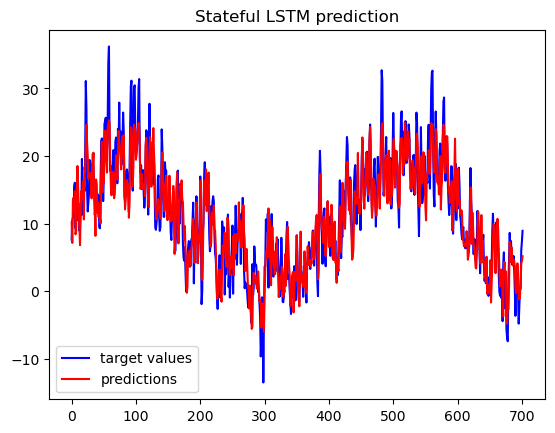

In [16]:
x = np.arange(test_num)
plt.plot(x, test_targets, label = 'target values', color='b')
plt.plot(x, predictions, label = 'predictions', color='r')
plt.title('Stateful LSTM prediction')
plt.legend()
plt.show()

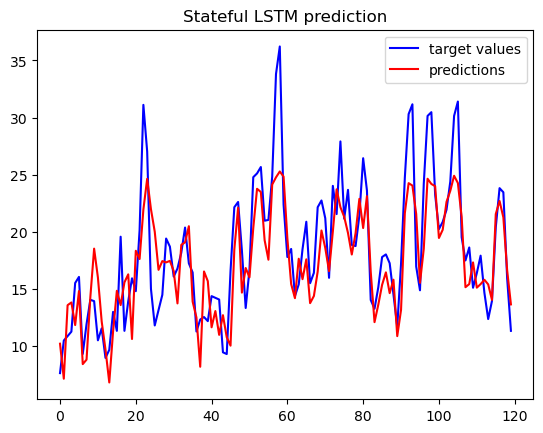

In [17]:
x = np.arange(120)
plt.plot(x, test_targets[:120], label = 'target values', color='b')
plt.plot(x, predictions[:120], label = 'predictions', color='r')
plt.title('Stateful LSTM prediction')
plt.legend()
plt.show()